In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from Utils import *
from Evaluation import *
from Classes import ABQuadrupel
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd

# Hefekulturen

## Define Files to Evaluate

Please edit the path to the reference plate (`path_to_reference_plate`) and experiment plate (`path_to_experiment_plate`) as well as the folder to save the results to (`save_results_folder`)

**Attention** Please make sure that the images are cropped, in such way that only the yeast colonies are visible.

In [35]:
path_to_reference_plate = r"Y:\PySplitUbi_DataFiles\Test\36_MPC_ref_d3_test.JPG"
path_to_experiment_plate = r"Y:\PySplitUbi_DataFiles\Test/36_MPC_Cu50_d3_test.JPG"
save_results_folder = r"Y:\PySplitUbi_DataFiles\Test/Results2/"

In [36]:
# IMG_SIZE = 8
MIN_COLONY_SIZE = 250
P_VALUE_NULLHYPOTHESIS = 0.01

In [37]:
os.makedirs(save_results_folder, exist_ok=True)

## Open and Preprocess Images

### Open Images as Binary

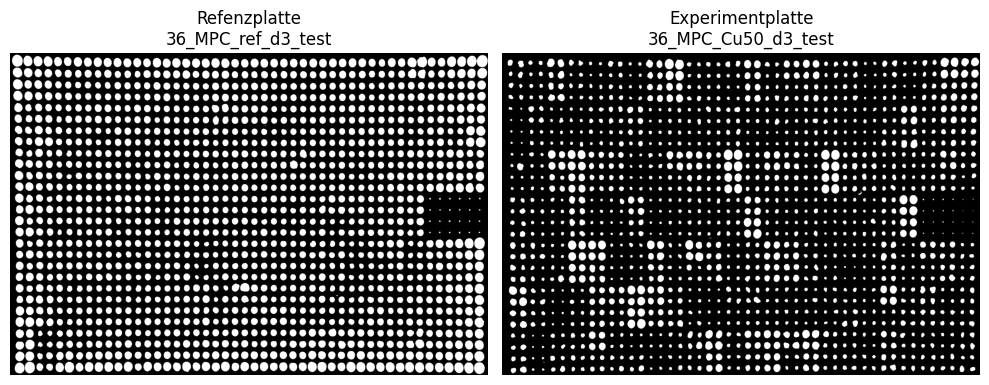

In [38]:
reference_plate = open_image(path_to_reference_plate)
experiment_plate = open_image(path_to_experiment_plate)

fig, axs = plt.subplots(1,2, figsize = (10,10*2))
axs[0].imshow(reference_plate, cmap="gray")
axs[1].imshow(experiment_plate, cmap="gray")
axs[0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
axs[1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.tight_layout()
plt.show()

### Compute Colony Sizes

Hint: if grid is not working properly, try to increase/decrease `erosion_iterations` by $\pm 1$

In [39]:
erosion_iterations_ref = 5
erosion_iterations_exp = 4


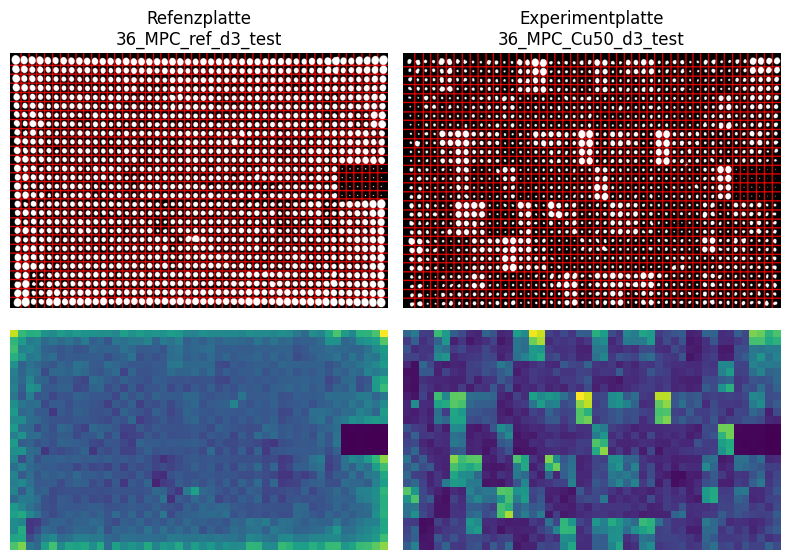

In [40]:
rgb_grid_reference, xmins_idx_reference, ymins_idx_reference = compute_grid(reference_plate, erosion_iterations = erosion_iterations_ref)
rgb_grid_experiment, xmins_idx_experiment, ymins_idx_experiment = compute_grid(experiment_plate, erosion_iterations = erosion_iterations_exp)

sizes_reference,_,_,_,_ = compute_sizes(reference_plate, xmins_idx_reference, ymins_idx_reference)
sizes_experiment, x_start, x_end, y_start, y_end = compute_sizes(experiment_plate, xmins_idx_experiment, ymins_idx_experiment)

fig, axs = plt.subplots(2,2, figsize = (4*2,4*1.5))
axs[0,0].imshow(rgb_grid_reference)
axs[0,1].imshow(rgb_grid_experiment)
axs[0,0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
axs[0,1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
axs[0,0].set_axis_off()
axs[0,1].set_axis_off()

axs[1,0].imshow(sizes_reference) #, cmap= "plasma")
axs[1,1].imshow(sizes_experiment) #, cmap= "plasma")
axs[1,0].set_axis_off()
axs[1,1].set_axis_off()
plt.tight_layout()
plt.autoscale(False)
plt.show()

## Evaluate
- Normalize experimental plate in relation to reference plate
- Find invalid quadruples
- Find siginificant differences between row A and row B
- Find quadruple where either all colonies of the row A quadruple or all colonies of the row B quadruple is larger than median of reference plate
- Saves .pdf into results folder with images

**Open questions: Currently sizes > median of reference plate but probably mean growth of quadruple > than mean growth of corresponting quadruple on the reference plate?**

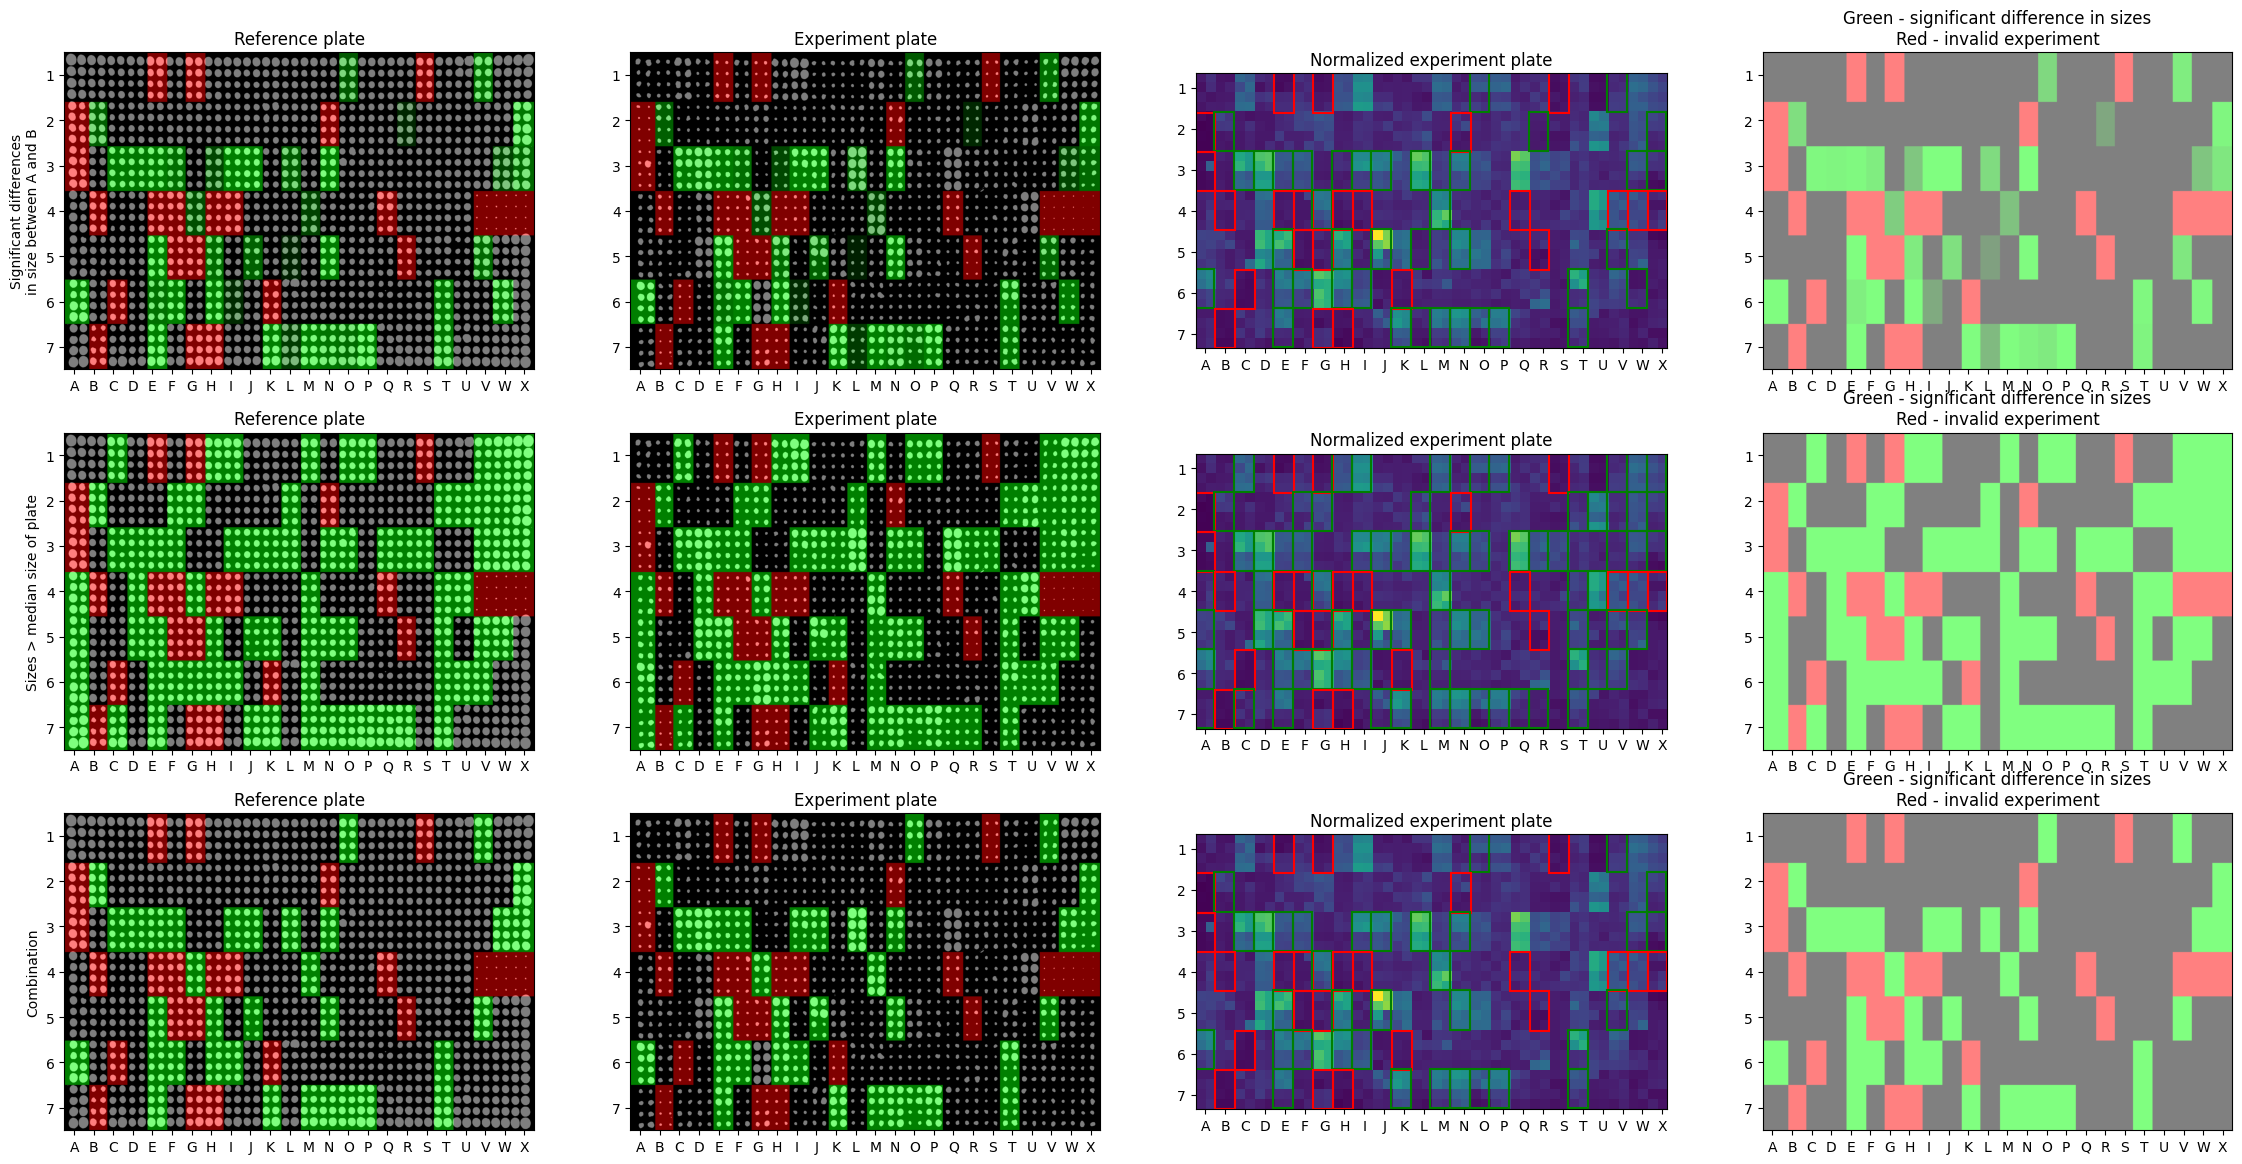

In [41]:
quadruples = evaluate(experiment_plate, reference_plate, sizes_experiment, sizes_reference, x_start, x_end, y_start, y_end, MIN_COLONY_SIZE, P_VALUE_NULLHYPOTHESIS, log_dir = save_results_folder+"Result_"+str(Path(path_to_experiment_plate).stem)+".pdf")

## Save Data to Excel Sheet

In [43]:

data = {'position': [quad.position[1]+" "+quad.position[0] for quad in quadruples], 
        'name': [str(quad.name) for quad in quadruples], 
        'p-value': [quad.p_value for quad in quadruples], 
        'bigger than median': [quad.bigger_than_median for quad in quadruples],
        'is valid' : [quad.is_valid for quad in quadruples], 
        'sizes A': [str(quad.quadrupelA.sizes) for quad in quadruples], 
        'sizes B': [str(quad.quadrupelB.sizes) for quad in quadruples]}
df = pd.DataFrame(data=data)    
df = df.sort_values(by=['p-value'])
df.to_excel(save_results_folder+"/Result_"+str(Path(path_to_experiment_plate).stem)+".xlsx")
df

,position,name,p-value,bigger than median,is valid,sizes A,sizes B
148,E 7,,0.000003,True,True,[1.06253653 0.95541023 0.95208214 1.03863382],[0.35518158 0.34467521 0.27820815 0.28511867]
4,E 1,,0.000006,False,False,[0.14936441 0.13546706 0.13176996 0.17715079],[0.33693305 0.34849545 0.37707091 0.3712651 ]
125,F 6,,0.000006,True,True,[1.00439883 1.05854801 1.03839869 0.94586234],[0.52967172 0.44223363 0.5206117 0.54487179]
159,P 7,,0.000007,True,True,[1.0979553 1.08854427 0.98241206 1.05973121],[0.54620123 0.53419913 0.4237338 0.49243996]
61,N 3,,0.000007,True,True,[1.11871227 1.11719253 1.02631579 1.0592503 ],[0.57793457 0.67261905 0.6505295 0.63613069]
...,...,...,...,...,...,...,...
82,K 4,,0.931600,False,True,[0.32 0.47835821 0.28072838 0.27879677],[0.33551769 0.32225914 0.31039427 0.37160752]
81,J 4,,0.940098,False,True,[0.38306452 0.40445402 0.30691531 0.33465871],[0.39093851 0.37584803 0.32533733 0.32823366]
39,P 2,,0.955193,False,True,[0.37683941 0.3314849 0.362148 0.53900293],[0.35370611 0.44162088 0.42274247 0.40341989]
126,G 6,,0.971894,True,True,[1.85291944 1.74326241 1.54173913 1.57863696],[1.79135618 1.58793605 1.71489362 1.60954447]
